In [96]:
import urllib.request
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [67]:
url = "https://github.com/alexeygrigorev/datasets/raw/refs/heads/master/jamb_exam_results.csv"

urllib.request.urlretrieve(url, "jamb_exam_results.csv")

('jamb_exam_results.csv', <http.client.HTTPMessage at 0x16521f590>)

In [68]:
df = pd.read_csv("jamb_exam_results.csv")

In [69]:
df.columns = df.columns.str.strip().str.lower().str.replace(" ", "_")

In [70]:
del df["student_id"]

In [71]:
for col in df.dtypes[df.dtypes == "object"].index:
    df[col] = df[col].str.strip().str.lower()

In [72]:
df.head(2)

,jamb_score,study_hours_per_week,attendance_rate,teacher_quality,distance_to_school,school_type,school_location,extra_tutorials,access_to_learning_materials,parent_involvement,it_knowledge,age,gender,socioeconomic_status,parent_education_level,assignments_completed
0,192,22,78,4,12.4,public,urban,yes,yes,high,medium,17,male,low,tertiary,2
1,207,14,88,4,2.7,public,rural,no,yes,high,high,15,male,high,NaN,1


In [73]:
df.fillna(0, inplace=True)

In [74]:
df.isna().sum()

jamb_score                      0
study_hours_per_week            0
attendance_rate                 0
teacher_quality                 0
distance_to_school              0
school_type                     0
school_location                 0
extra_tutorials                 0
access_to_learning_materials    0
parent_involvement              0
it_knowledge                    0
age                             0
gender                          0
socioeconomic_status            0
parent_education_level          0
assignments_completed           0
dtype: int64

In [75]:
df.head(2)

,jamb_score,study_hours_per_week,attendance_rate,teacher_quality,distance_to_school,school_type,school_location,extra_tutorials,access_to_learning_materials,parent_involvement,it_knowledge,age,gender,socioeconomic_status,parent_education_level,assignments_completed
0,192,22,78,4,12.4,public,urban,yes,yes,high,medium,17,male,low,tertiary,2
1,207,14,88,4,2.7,public,rural,no,yes,high,high,15,male,high,0,1


In [76]:
from sklearn.model_selection import train_test_split

df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = df_train["jamb_score"]
y_val = df_val["jamb_score"]
y_test = df_test["jamb_score"]

del df_train["jamb_score"]
del df_val["jamb_score"]
del df_test["jamb_score"]

In [77]:
from sklearn.feature_extraction import DictVectorizer

dv = DictVectorizer(sparse=True)

train_dict = df_train.to_dict(orient="records")
dv.fit(train_dict)
X_train = dv.transform(train_dict)
X_val = dv.transform(df_val.to_dict(orient="records"))
X_test = dv.transform(df_test.to_dict(orient="records"))


In [79]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import export_text

dt = DecisionTreeRegressor(max_depth=1)
dt.fit(X_train, y_train)

print(export_text(dt, feature_names=dv.get_feature_names_out()))

|--- study_hours_per_week <= 18.50
|   |--- value: [155.24]
|--- study_hours_per_week >  18.50
|   |--- value: [188.59]



In [81]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import root_mean_squared_error

rf = RandomForestRegressor(n_estimators=10, random_state=1, n_jobs=-1)
rf.fit(X_train, y_train)
root_mean_squared_error(y_val, rf.predict(X_val))

42.13724207871227

In [85]:
scores = dict()
for n_est in range(10, 201, 10):
    rf = RandomForestRegressor(n_estimators=n_est, random_state=1, n_jobs=-1)
    rf.fit(X_train, y_train)
    rmse = root_mean_squared_error(y_val, rf.predict(X_val))
    scores.update({n_est: rmse})

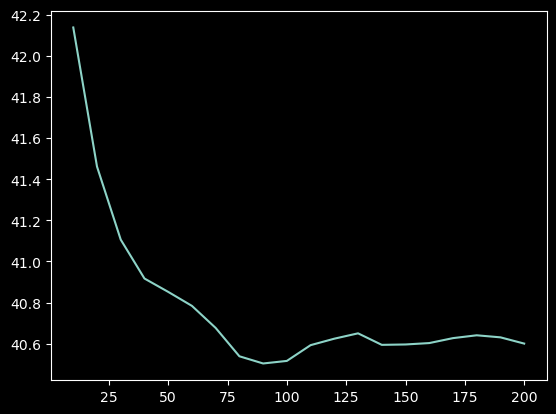

In [88]:
scores_df = pd.DataFrame(scores.items(), columns=["n_estimators", "rmse"])

plt.plot(scores_df["n_estimators"], scores_df["rmse"])

In [99]:
scores_b = dict()

for depth in [10, 15, 20, 25]:
    _intermediate_scores = []
    for n_est in range(10, 201, 10):
        rf = RandomForestRegressor(n_estimators=n_est, max_depth=depth, random_state=1, n_jobs=-1)
        rf.fit(X_train, y_train)
        rmse = root_mean_squared_error(y_val, rf.predict(X_val))
        _intermediate_scores.append(rmse)
    scores_b.update({depth: np.mean(_intermediate_scores)})

scores_b_df = pd.DataFrame(scores_b.items(), columns=["max_depth", "rmse"])

In [102]:
scores_b_df.sort_values(by="rmse", ascending=True)

,max_depth,rmse
0,10,40.392498
1,15,40.735282
2,20,40.739734
3,25,40.787866


In [106]:
model_fi = RandomForestRegressor(max_depth=20, random_state=1, n_estimators=10, n_jobs=-1)
model_fi.fit(X_train, y_train)
model_fi.feature_importances_

array([0.0123254 , 0.01026189, 0.06931145, 0.03151679, 0.14972903,
       0.1364858 , 0.01345934, 0.00913136, 0.00928871, 0.01038263,
       0.01771934, 0.01240405, 0.00914148, 0.        , 0.01545036,
       0.01695692, 0.01448862, 0.02291885, 0.01335761, 0.01149201,
       0.00955909, 0.00923932, 0.0089532 , 0.00840598, 0.02571426,
       0.01070798, 0.01056268, 0.24835361, 0.08268222])

In [108]:
dv.get_feature_names_out()[np.argmax(model_fi.feature_importances_)]

'study_hours_per_week'

In [110]:
import xgboost as xgb

dmatrix_train = xgb.DMatrix(X_train, label=y_train, feature_names=dv.feature_names_)
dmatrix_val = xgb.DMatrix(X_val, label=y_val, feature_names=dv.feature_names_)

xgb_params_a = {
    "eta": 0.3,
    "max_depth": 6,
    "min_child_weight": 1,
    "objective": "reg:squarederror",
    "nthread": 8,
    "seed": 1,
    "verbosity": 1,
}

xgb_params_b = {
    "eta": 0.1,
    "max_depth": 6,
    "min_child_weight": 1,
    "objective": "reg:squarederror",
    "nthread": 8,
    "seed": 1,
    "verbosity": 1,
}

xgba = xgb.train(xgb_params_a, dmatrix_train, num_boost_round=100)
xgbb = xgb.train(xgb_params_b, dmatrix_train, num_boost_round=100)

xgb_pred_a = xgba.predict(dmatrix_val)
xgb_pred_b = xgbb.predict(dmatrix_val)

rms_a, rms_b = root_mean_squared_error(y_val, xgb_pred_a), root_mean_squared_error(y_val, xgb_pred_b)

print(f"Model A RMSE: {rms_a}, Model B RMSE: {rms_b}")

Model A RMSE: 43.418817345871766, Model B RMSE: 41.05034017683498
